# Agentic Patterns: ReAct, Plan-Execute, and Reflection

In [ ]:
# Imports
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated

import operator
import os

print("All imports successful")

All imports successful


In [45]:
load_dotenv()
api_key = os.getenv("paid_api2")

if not api_key:
    raise ValueError("API_Key not found. Please set it in your .env file")
print("API key loaded")

API key loaded


In [46]:
## Initialize LLM
llm = ChatOpenAI(
    model = "gpt-4o-mini",
    temperature=0.5,
    api_key = api_key
)
print(f"LLM initialized: {llm.model_name}")

LLM initialized: gpt-4o-mini


## ReAct Pattern

## Plan-Execute Pattern

### Implementation

In [47]:
#Customized state for plan-execute
class PlanExecuteState(TypedDict):
    """State for plan-execute pattern."""
    input: str 
    plan: list[str]
    current_step: int
    results: Annotated[list[str], operator.add] #Results from each step
    final_output: str

print("Plan-Execute state defined")

Plan-Execute state defined


In [48]:
# Node 1: Planner
def planner(state: PlanExecuteState) -> dict:
    """Create a step-by-step plan."""
    prompt = f"""Create a step-by-step plan for this task:

Task: {state['input']}

Return a numbered list of concrete steps. Keep it simple (3-5 steps)."""
    
    response = llm.invoke([HumanMessage(content=prompt)])

    # Parse steps (simple parsing)
    lines = response.content.split('\n')
    steps = [line.strip() for line in lines if line.strip() and any(char.isdigit() for char in line[:3])]

    print(lines)
    print(f"\n📋 PLAN CREATED:")
    for step in steps:
        print(f"    {step}")
    print()

    return {"plan": steps, "current_step": 0, "results": []}

# Node 2: Executor
def executor(state: PlanExecuteState) -> dict:
    """Execute current step."""
    if state["current_step"] >= len(state["plan"]):
        #All steps done
        return {}
    
    current_step = state["plan"][state["current_step"]] #maps current step to a planned task

    print(f"Executing: {current_step}")

    # Execute step (simplified - just use LLM)
    prompt = f"""Previous results: {state.get('results', [])}\n\nExecute this step: {current_step}"""
    response = llm.invoke([HumanMessage(content=prompt)])

    result = f"Step {state['current_step']+1} result: {response.content}"
    print(result)
    print(f"✓ Done\n")

    return {
        "results": [result],
        "current_step": state["current_step"]+1
    }

#Node Finalizer
def finalizer(state: PlanExecuteState) -> dict:
    """Create final output from all results."""
    prompt = f"""Combine these step results into final answer:

Original task: {state['input']}

Results: {state['results']}

Provide a clear, concise final answer."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"final_output": response.content}

print("Plan-Execute nodes defined")

Plan-Execute nodes defined


In [49]:
# Routing function
def should_continue_execution(state: PlanExecuteState) -> Literal["executor", "finalizer"]:
    """Decide if more steps to execute."""
    if state["current_step"] < len(state["plan"]):
        return "executor"
    return "finalizer"

#Build Plan-Execute graph
plan_execute_builder = StateGraph(PlanExecuteState)

plan_execute_builder.add_node("planner", planner)
plan_execute_builder.add_node("executor", executor)
plan_execute_builder.add_node("finalizer", finalizer)

plan_execute_builder.add_edge(START, "planner")
plan_execute_builder.add_edge("planner", "executor")
plan_execute_builder.add_conditional_edges(
    "executor",
    should_continue_execution,
    {"executor": "executor", "finalizer": "finalizer"} #loops within executor until the preset conditions are met, then it moves to finalizer
)
plan_execute_builder.add_edge("finalizer", END)

plan_execute_agent = plan_execute_builder.compile() #Why are we not saving memory?

print("Plan-Executer agent created")

Plan-Executer agent created


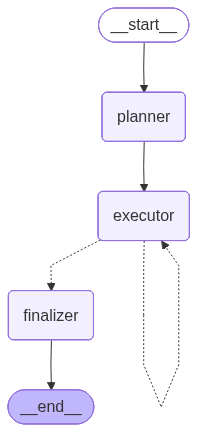

In [50]:
#Visualize
try:
    display(Image(plan_execute_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → planner → executor (loops) → finalizer → END")

### Test Plan-Execute

In [51]:
result = plan_execute_agent.invoke({
    "input": "Research what ReAct pattern is and explain it simply"
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT:")
print(f"{'='*70}")
print(result["final_output"])
print(f"{'='*70}\n")

['Sure! Here’s a simple step-by-step plan to research the ReAct pattern and explain it:', '', '1. **Define the Scope**: Start by clarifying what the ReAct pattern is. Identify its context, such as whether it pertains to programming, psychology, or another field.', '', '2. **Conduct Online Research**: Use reliable sources like academic articles, reputable websites, and documentation to gather information about the ReAct pattern. Look for definitions, examples, and applications.', '', '3. **Summarize Key Points**: Take notes on the most important aspects of the ReAct pattern, focusing on its purpose, components, and how it works. Aim to simplify complex ideas.', '', '4. **Create a Simple Explanation**: Write a clear and concise explanation of the ReAct pattern in your own words, ensuring it is easy to understand for someone without background knowledge.', '', '5. **Review and Revise**: Read through your explanation to ensure clarity and simplicity. Make any necessary adjustments to impro

## Reflection Pattern

### Implementation

In [52]:
# Cutomised state for Reflection
class ReflectionState(TypedDict):
    """State for reflection pattern."""
    task: str # Original task
    draft: str # Current draft
    critique: str # Critique of draft
    iterations: int  # Number of refinements
    final_output: str  # Final result

MAX_REFLECTIONS = 2 # prevents infinite loops
print("Reflection state defined")

Reflection state defined


In [53]:
# Node 1: Generator
def generator(state: ReflectionState) -> dict:
    """Generate or refine based on critique."""
    if state["iterations"] == 0:
        # First generation
        prompt = f"""Create a response for this task:
Task: {state['task']}

Provide a clear, complete answer."""
        print("\nGenerating initial draft...")

    else:
        #refinement based on critique
        prompt = f"""Improve this draft based on the critique:

Task: {state['task']}

Current draft: {state['draft']}

Critique: {state['critique']}
"""
        print(f"\nRefining (iteration {state['iterations']})...")\
    

    response = llm.invoke([HumanMessage(content=prompt)])
    print("✓ Draft created\n")

    return {"draft": response.content}


#Node 2: Critic
def critic(state: ReflectionState) -> dict:
    """Evaluate draft and provide critique."""
    prompt = f"""Evaluate this response and provide constructive critique:

Task: {state['task']}

Response: {state['draft']}

Critique the response. What could be improved?
If it's excellent, say "APPROVED: explanation".
Otherwise, provide specific improvements needed."""
    
    print("Critiquing draft...")
    response = llm.invoke([HumanMessage(content=prompt)])
    critique = response.content

    print(f"Critique: {critique[:100]}\n")

    return {
        "critique": critique,
        "iterations": state["iterations"] + 1
    }

# Node 3: Finalizer
def reflection_finalizer(state: ReflectionState) -> dict:
    """Set final output."""
    print("\nReflection complete\n")
    return {"final_output": state["draft"]}

print("Reflection nodes defined")

Reflection nodes defined


In [54]:
# Routing function
def should_reflect_again(state: ReflectionState) -> Literal["generator", "finalizer"]:
    """Decide if we need more refinement."""
    # Stop iterations if draft is approved or max iteration is reached
    if "APPROVED" in state.get('critique', "").upper(): #retuns an empty string if APPROVED is not found
        return "finalizer"
    
    if state['iterations'] >= MAX_REFLECTIONS:
        print(f"Max iterations ({MAX_REFLECTIONS}) reached\n")
        return "finalizer"
    
    return "generator"

# Build Reflection graph
reflection_builder = StateGraph(ReflectionState)

reflection_builder.add_node("generator", generator)
reflection_builder.add_node("critic", critic)
reflection_builder.add_node("finalizer", reflection_finalizer)

reflection_builder.add_edge(START, "generator")
reflection_builder.add_edge("generator", "critic")
reflection_builder.add_conditional_edges(
    "critic",
    should_reflect_again,
    {"generator": "generator", "finalizer": "finalizer"}
)
reflection_builder.add_edge("finalizer", END)

reflection_agent = reflection_builder.compile()

print("Reflection agent created")

Reflection agent created


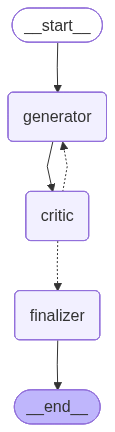

In [55]:
# Visualize
try:
    display(Image(reflection_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Graph: START → generator → critic (loops back to generator) → finalizer → END")

### Test Reflection

In [56]:
result = reflection_agent.invoke({
    "task": "Explain what an agentic pattern is in 2-3 sentences",
    "draft": "",
    "critique": "",
    "iterations": 0
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT (after reflection):")
print(f"{'='*70}")
print(result["final_output"])
print(f"\nTotal iterations: {result['iterations']}")
print(f"{'='*70}\n")


Generating initial draft...
✓ Draft created

Critiquing draft...
Critique: The response provides a clear and concise definition of an agentic pattern, effectively capturing it


Refining (iteration 1)...
✓ Draft created

Critiquing draft...
Critique: The response provides a clear and concise definition of an agentic pattern, highlighting autonomy an

Max iterations (2) reached


Reflection complete


📊 FINAL OUTPUT (after reflection):
**Revised Response**: An agentic pattern is a way of acting in which individuals take control of their actions and decisions, showing autonomy. This concept emphasizes how people can shape their environments and outcomes through deliberate choices. For instance, someone who actively pursues new job opportunities exemplifies an agentic pattern by taking charge of their career development.

Total iterations: 2

